In [70]:
import numpy as np
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import pnorm, upsample, firFilter, pulseShape, signal_power
from optic.models.devices import mzm
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram

# Transmissores Opticos

O primeiro passo para este estudo é entender como representar os sinais nas diferentes etapas do sistema. 

Ao transmitir sinais em um canal de comunicação como a fibra óptica, a intensidade e a fase da portadora são modificadas para transmitir informações tal processo e chamado de **modulação** o sinal modulado pode ser representado da seguinte maneira.

$$x(t)=\sqrt{2}A(t)\mathrm{cos}(2\pi f_{c}t+\phi(t))$$

onde $f_{c}$ é a frequência da portadora e $A(t)$ e $\phi(t)$ são a amplitude e a fase sendo os principais componentes de modulação. De forma alternativa podemos adotar outra representação dos sinais transmitidos que podem suprimir a dependência da frequência da portadora usando números complexos.

$$x_{b}(t)=x_{I}(t)+i x_{Q}(t).$$

Ou ainda podemos observala como representação fasorial cartesiana:

$$x(t)=i A\sin\left(\theta\right)+A\cos\left(\theta\right)$$
$$x_{I}=A\cos\left(\theta\right)$$
$$x_{Q}=A\sin\left(\theta\right)$$

O sinal $x(t)$ e a representação do sinal em banda base. Em sistemas de transmissão digital com modulação de amplitude de pulso em banda base
(PAM), os sinais de tempo contínuo $x_{I}(t)$ e $x_{Q}(t)$ podem ser expressos como uma soma de
formas de onda contínuas com atraso de tempo onde $Ts$ é o período do símbolo.

$$\begin{array}{c}{{x_{I}(t)=\sum_{k}x_{k}^{I}g(t-k T_{s}),}}\\ {{{}}}\\ {{{x}_{Q}(t)=\sum_{k}x_{k}^{Q}g(t-k T_{s}),}}\end{array}$$

Uma família amplamente utilizada de formatos de modulação que alcança excelente desempenho é a modulação de amplitude em quadratura M-ária (M-QAM). No M-QAM, os níveis de amplitude M dos componentes em fase e quadratura são uniformemente distribuído e modulado independentemente. Normalmente, $M = L²$ e $L$ é uma potência de dois. Para fins de visualização podemos gerar diferentes formatos de modulação e suas respectivas constelações.

### Diagramas de Constelação

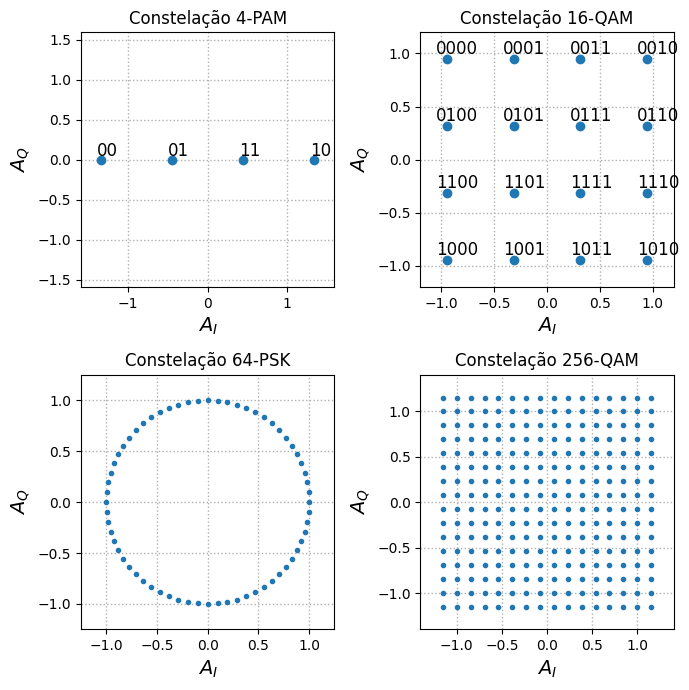

In [71]:
M = [4, 16, 64, 256]  # Ordem do formato de modulação.
constType = ['pam', 'qam', 'psk', 'qam']  # 'qam', 'psk', 'pam' or 'ook'

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

for idx, modulation in enumerate(M):
    # Gera os pontos cartesianos da constelação neste caso fasores para cada simbolo.
    constSymb = GrayMapping(modulation, constType[idx])
    # Gera o mapeamento de bits, agrupando bits em matrizes para cada simbolo.
    bitMap = demodulateGray(constSymb, modulation, constType[idx])
    bitMap = bitMap.reshape(-1, int(np.log2(modulation)))

    # Tomando uma sequência de bits aleatória.
    bits = bitMap.reshape(1, -1)
    # Mapeia os bits para os simbolos da constelação como um fasor.
    symbTx = modulateGray(bits, modulation, constType[idx])

    # normaliza os simbolos da constelação para terem energia igual a 1.
    symbTx = pnorm(symbTx)

    row = idx // 2
    col = idx % 2

    # Plota a Constelação M-ária
    if modulation < 64:
        axs[row,col].plot(symbTx.real, symbTx.imag, 'o', markersize=6)
        axs[row,col].set_title('Constelação ' + str(modulation) + '-' + constType[idx].upper())

        axs[row,col].set_xlim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row,col].set_ylim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row,col].set_xlabel('$A_I$', fontsize='14')
        axs[row,col].set_ylabel('$A_Q$', fontsize='14')
        axs[row,col].grid(linestyle="dotted", linewidth=1)

        for ind, symb in enumerate(pnorm(constSymb)):
            bitMap[ind, :]
            axs[row, col].annotate(str(bitMap[ind, :])[1:-1:2], xy=(symb.real - 0.025 * np.log2(modulation), symb.imag + 0.05), size=12)
    else:
        axs[row,col].plot(symbTx.real, symbTx.imag, 'o', markersize=3)
        axs[row,col].set_title('Constelação ' + str(modulation) + '-' + constType[idx].upper())

        axs[row,col].set_xlim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row,col].set_ylim(min(symbTx.real) - 0.25, max(symbTx.real) + 0.25)
        axs[row,col].set_xlabel('$A_I$', fontsize='14')
        axs[row,col].set_ylabel('$A_Q$', fontsize='14')
        axs[row,col].grid(linestyle="dotted", linewidth=1)

plt.tight_layout()
plt.show()

### 2.1 Critério de Nyquist e ISI

O critério de Nyquist determina a existência de uma família de formas de pulso para $g(t)$ cuja transmissão é realizada livre de interferência intersimbólica (ISI) essa é a condição para transmissão livre de ISI que pode ser expressa como:

$$\frac{1}{T_{s}}\sum_{m=-\infty}^{\infty}G\left(f-\frac{m}{T_{s}}\right)=1$$

A transmissão livre de ISI é alcançada se a soma das versões com mudança de frequência de $G(f)$ resulta em uma constante. Pulsos satisfatórios
para esta condição são chamados de pulsos de Nyquist. A forma do pulso de Nyquist com o mínimo de largura de banda de transmissão, $1/(2Ts)$, é obtida por um formato de pulso sinc:

$$g(t)=\frac{\sin(\pi t/T_{s})}{\pi t/T_{s}}$$

Os pulsos baseados na função sinc possuem duração infinita, o que dificulta sua aplicação prática. Alternativamente, os pulsos de cosseno elevado (RC) são pulsos de Nyquist cuja duração espectral e suporte são controlados por um fator de roll-off $\alpha^{\mathrm{RC}}$ que podem variar de 0 a 1. A resposta de frequência do filtro de modelagem RC é dada por:

$$H_{\mathrm{RC}}(f)={\left\{\begin{array}{l l}{1,{\mathrm{~if~}}|f|\lt {\frac{1-\alpha^{\mathrm{RC}}}{2T_{\mathrm{c}}}};}\\ {0,{\mathrm{~if~}}|f|\gt {\frac{1+\alpha^{\mathrm{RC}}}{2T_{\mathrm{s}}}};}\\ 

{0.5+0.5\mathrm{cos}\left({\frac{\pi}{\alpha^{\mathrm{RC}}}}\left(|f|-\frac{1-\alpha^{\mathrm{RC}}}{2T_{\mathrm{s}}}\right)\right),

{\mathrm{~if~}}{\frac{1+\alpha^{\mathrm{RC}}}{2T_{\mathrm{s}}}}\gt |f|\gt {\frac{1-\alpha^{\mathrm{RC}}}{2T_{\mathrm{s}}}}}\end{array}\right.}$$

Em sistemas ópticos coerentes é possível trabalhar com fatores de roll-off bastante baixos, variando de 0.01 a 0.1, implementando um pulso
com espectro quase retangular. Porém, a geração de pulsos com valores tão baixos de roll-off são complexos, exigindo filtros moldados com centenas de coeficientes.

### Exemplo e Visualização

Quando você aplica um filtro de modelagem de pulso, ele alonga o pulso no domínio do tempo (para condensá-lo em frequência), o que faz com que os símbolos adjacentes se sobreponham.

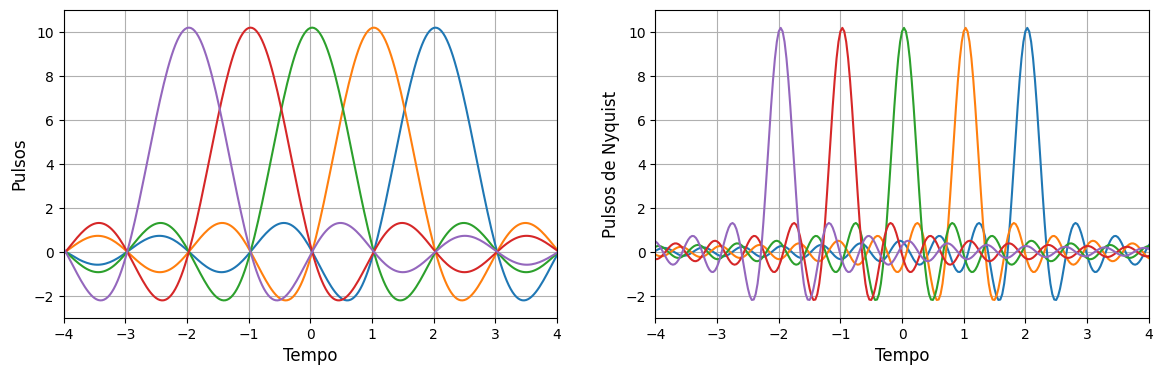

In [72]:
SpS = 32  # Taxa de símbolos
Ts = SpS  # Supondo que a taxa de amostragem seja 1 Hz, então o período de amostragem é 1.

num_taps = 2001
t = np.arange(num_taps // -2, num_taps // 2)

sinc = np.sinc(t / Ts)
sinc_Nyquist = np.sinc(np.pi * t/ Ts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

for delay in np.arange(-2, 3):
    x_shaped = np.convolve(np.sinc(np.pi*(t + delay * SpS) / Ts), sinc, 'same')
    x_nyquist = np.convolve(np.sinc(np.pi*(t + delay * SpS) / Ts), sinc_Nyquist, 'same')
    ax1.plot(t / Ts, x_shaped)
    ax2.plot(t / Ts, x_nyquist)

for plot in [ax1, ax2]:
    plot.axis([-3, 3, -3, 11])
    plot.set_xlabel("Tempo", fontsize=12)
    plot.set_ylabel("Pulsos", fontsize=12)
    if plot == ax2:
        plot.set_ylabel("Pulsos de Nyquist")
    plot.set_xticks(np.arange(-4, 5));
    plot.grid()

Quando o receptor amostra o sinal, ele o faz no momento perfeito (no pico dos pulsos), o que significa que esse é o único momento que importa. Geralmente há um bloco de sincronização de símbolos no receptor que garante que os símbolos sejam amostrados nos picos.

Resposta ao Impulso do filtro:
$$h(t)=\frac{1}{T}\mathrm{sinc}\left(\frac{t}{T}\right)\frac{\cos\left(\frac{\pi\beta t}{T}\right)}{1-\left(\frac{2\beta t}{T}\right)^{2}}$$

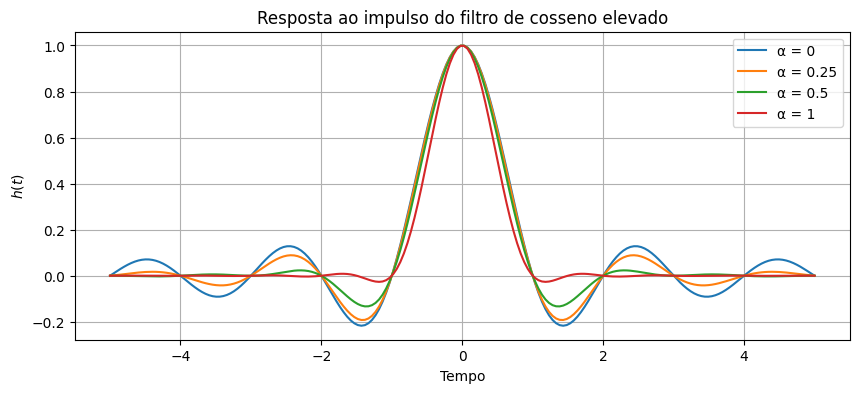

In [73]:
SpS = 4
t = np.linspace(-5*SpS, 5*SpS, 200)

rolloff = []
plt.figure(num=None, figsize=(10, 4))

for alpha in [0, 0.25, 0.5, 1]:
    h = np.sinc(t/SpS)*np.cos(np.pi*alpha*t/SpS)/(1-(2*alpha*t/SpS)**2) # Resposta ao impulso do filtro.
    plt.plot(t/SpS, h)
    rolloff.append('α = ' + str(alpha))

plt.title("Resposta ao impulso do filtro de cosseno elevado")
plt.xlabel("Tempo")
plt.ylabel("$h(t)$")
plt.legend(rolloff)
plt.grid(True)

Assim o filtro pode limitar a largura de banda que nosso sinal ocupará, cuja duração espectral e suporte são controlados por um fator de roll-off $\alpha$ que determina a rapidez com que o filtro diminui no domínio do tempo, o que será inversamente proporcional à rapidez com que diminui em frequência.

Uma vez que olhamos para as respostas do filtro em diferentes valores de $\alpha$, podemos ver que a largura de banda necessária para capturar nosso sinal aumenta e é daí que vem seu outro nome, excesso de largura de banda. O parâmetro $\alpha$ é uma compensação entre quanto vazamento espectral você está permitindo para frequências próximas e quanta largura de banda será necessária para recuperar o sinal transmitido.

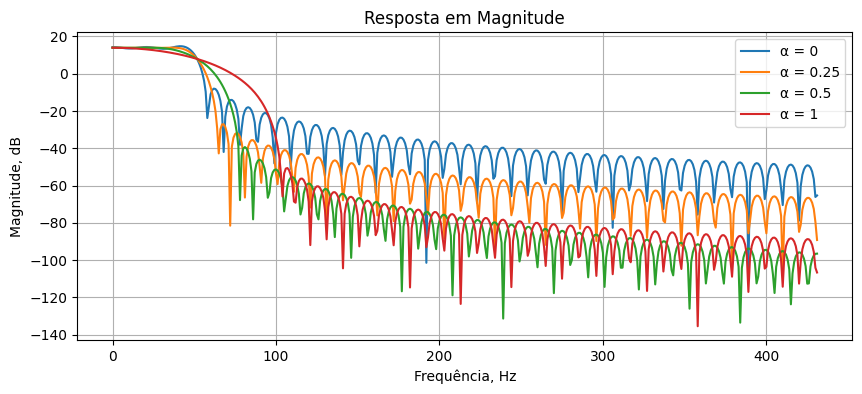

In [74]:
SpS = 4
fft_size = 2064
t = np.linspace(-5*SpS, 5*SpS, 200)

rolloff = []
plt.figure(num=None, figsize=(10, 4))

for alpha in [0, 0.25, 0.5, 1]:
    h = np.sinc(t/SpS)*np.cos(np.pi*alpha*t/SpS)/(1-(2*alpha*t/SpS)**2)
    rcos_response = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(h, fft_size)))/SpS)
    plt.plot(rcos_response[int(fft_size/2):-600])
    rolloff.append('α = ' + str(alpha))

plt.title("Resposta em Magnitude")
plt.xlabel("Frequência, Hz")
plt.ylabel("Magnitude, dB")
plt.legend(rolloff)
plt.grid(True)

## Modulação Óptica

### 2.2 Lasers

Em sistemas de comunicações ópticas, a portadora é geralmente produzida por semicondutores lasers e diodos emissores de luz (LEDs). Para transmissão de longa distância com
detecção, vamos assumir que todas as portadores são gerados por lasers.

As principais vantagens de lasers sobre outras fontes de luz são seu feixe colimado, intensidades relativamente altas e coerência. Para transmissão óptica de longa distância, a coerência é de fundamental importância, especialmente para sistemas com modulação de fase e detecção coerente. À medida que modulamos a fase da portadora gerada, o ruído de fase deve ser relativamente baixo para evitar prejuízos no processo de detecção. Os lasers usados na detecção coerente requerem uma largura de linha particularmente estreita, para servir como uma fonte de referência adequada para detecção de fase.

Vamos supor que a saída do laser tenha intensidade constante (desprezando assim a intensidade do ruído), o campo elétrico em sua saída é dado por:

$$E_{l}(t)=E_{0}e^{j\phi_{n}(t)}$$

onde $E_0$ é uma amplitude de campo constante e $\phi_{n}(t)$ é o processo de ruído de fase. A largura de linha diferente de zero dos lasers dá origem a um processo de ruído de fase que é bem modelado por um processo de Wiener de tempo contínuo. Também é importante sabermos que o ruído de fase dos lasers transmissores e receptores resulta em rotações nas constelações recebidas. Em sistemas ópticos coerentes, essas rotações são compensadas em DSP por algoritmos de recuperação de fase.

### 2.3 Optical Modulation

Em sistemas de comunicação por fibra óptica, a modulação direta é a técnica mais simples usada para modular uma portadora óptica. A modulação direta modifica a corrente de acionamento de um laser semicondutor causando variações na amplitude do sinal óptico gerado de acordo com a informação a ser enviada. 

Como desvantagem, esse tipo de modulação produz pulsos que são afetados pelo chirp, que são variações contínuas da frequência óptica durante um período de símbolo. Uma desvantagem da modulação direta é a incapacidade de acompanhar variações rápidas na tensão de acionamento. Apesar dessas desvantagens, a modulação é amplamente utilizada em sistemas ópticos de curto alcance com modulação de intensidade e detecção direta, principalmente por sua simplicidade e baixo custo.

Alternativamente, a modulação externa é usada na maioria dos sistemas de alta taxa. Esta técnica de modulação requer a utilização de um componente extra, o **modulador óptico**, que é acoplado na **saída da fonte óptica**. Variações de fase, amplitude ou uma combinação das duas podem ser realizadas de acordo com sinais elétricos representativos da informação a ser enviada. Embora aumente a complexidade do transmissor, a modulação externa proporciona um desempenho do sistema consideravelmente melhor em comparação com a modulação direta, minimizando vários efeitos indesejados, particularmente as limitações de chirp e de largura de banda.

<br>
<center>
    <img src="https://i.postimg.cc/rsM6s1fp/Screenshot-from-2024-02-24-22-23-50.png height="362" width="719">
</center>
<br>

Como foi visto acima em um sistema de comunicação digital óptica, a função do transmissor é converter uma dada sequência de bits num trem de pulsos elétricos que, por sua vez, será utilizado na modulação de uma portadora óptica (laser) seja modulando apenas a intensidade do sinal ou em amplitude e fase. A modulação de portadoras ópticas é realizada por meio de dispositivos de conversão eletro-óptica.

### 2.3.1 Phase Modulator

O modulador de fase (PM) é um dispositivo que depende do [efeito Pockels](https://pt.wikipedia.org/wiki/Efeito_Pockels) para imprimir variações na fase de uma portadora óptica. O esquema básico de um modulador de fase é mostrado na figura abaixo, onde $E_{input}(t)$ e $E_{output}(t)$ são os campos elétricos dos sinais ópticos de entrada e saída, respectivamente, e $v(t)$ é o sinal elétrico que aciona o PM.

<br>
<center>
    <img src="https://i.postimg.cc/52L0rJ4b/Screenshot-from-2024-02-19-19-47-46.png">
</center>
<br>

De acordo com o efeito Pockels, a aplicação de uma tensão elétrica externa em determinados materiais é capaz de modificar seu índice de refração. Consequentemente, o índice de refração efetivo de um guia de ondas também pode ser modificado dependendo do seu material. Usando este processo, uma tensão de acionamento modulada também pode modular a fase da portadora óptica que atravessa o guia de ondas de acordo com a informação a ser transmitida. O deslocamento de fase $\phi_{PM}$ é dado por:

$$\varphi_{P M}(t)=\frac{2\pi}{\lambda}{\Delta_{n_{e f\!f}}}(t)l_{i}$$

Onde $\lambda$ é o comprimento de onda operacional ${\Delta_{n_{e f\!f}}}$ é a variação do índice de refração efetivo e $l_{i}$ é o comprimento de interação. Em geral ${\Delta_{n_{e f\!f}}}$ e linearmente proporcional a $v(t)$, e a constante de proporcionalidade é geralmente apresentada em termos
da tensão que gera um deslocamento de fase de $\pi$ rad, conhecido como $V_{\pi}$

$$\frac{E_{\mathrm{output}}(t)}{E_{\mathrm{input}}(t)}=e^{j\varphi p_{M}(t)}=e^{j\frac{\pi}{V_{\pi}}v(t)}$$

### 2.3.2 Mach–Zehnder Modulator

In [75]:
def MZM(Vin, Vb, Vpi):
    return (np.cos(np.pi/2*(Vin+Vb)/Vpi))

 O dispositivo **March-Zehnder** (MZM) utiliza o princípio da interferência entre sinais de propagação para gerar uma modulação de amplitude e fase. Ele desempenha um papel importante na modulação de sinais ópticos, permitindo a manipulação eficiente da intensidade da luz em dispositivos ópticos.

Em breve veremos como é possível utilizalo para implementar o modulador IQM (*In-Phase and Quadrature Modulator*) que ao contrário do MZM permite gerar símbolos de constelação em qualquer posição do plano complexo.

<br>
<center>
    <img src="https://i.postimg.cc/RF3L3JxS/Screenshot-from-2024-02-13-20-30-57.png">
</center>
<br>

Como visto na figura acima o modulador consiste em dois moduladores de fase que permitem alterar o índice de refração de um guia de ondas proporcionalmente a uma tensão de acionamento.

Conforme a figura acima o sinal óptico que entra na estrutura é dividido em dois braços distintos. Em cada um desses braços, um modulador de fase atua na propagação sinal óptico realizando uma mudança de fase proporcional à tensão elétrica aplicada. Após esse processo, os sinais ópticos dos dois braços são recombinados e dependendo da diferença de fase entre eles, observa-se um padrão de interferência construtivo ou destrutivo. Esta estrutura do dispositivo dá origem à função de transferência:

$$\frac{E_{\mathrm{output}}(t)}{E_{\mathrm{input}}(t)}=\frac{1}{2}\left(e^{j\varphi p_{M_{1}}(t)}+e^{j\varphi p_{M_{2}}(t)}\right)$$

Onde $\varphi_{PM_{1}}\left(t\right)$ e $\varphi_{PM_{2}}\left(t\right)$ são as mudanças de fase experimentadas pelos sinais ópticos
nos braços superiores e inferiores do modulador. Os deslocamentos de fase 
$\varphi_{PM_{1}}\left(t\right)$ e $\varphi_{PM_{2}}\left(t\right)$ são dados por:

$$\begin{array}{c}{{\varphi_{PM_{1}}(t)=\frac{v_{1}(t)}{V_{\pi_{1}}}\pi}}\\ {{\varphi_{PM_{2}}(t)=\frac{v_{2}(t)}{V_{\pi_{2}}}\pi}}\end{array}$$

Onde $V_{\pi_1}$ e $V_{\pi_2}$ são os parâmetros $V_{\pi}$ para o modulador de fase em cada um dos braços. O modulador MZM possui a capacidade de admitir dois modos de operação, podendo modular o sinal apenas em fase ou amplitude, dependendo da relação entre as tensões elétricas que acionam os moduladores de fase.

Existem dois modos de operação principais. 

**$\varphi_{PM_{1}}\left(t\right) = \varphi_{PM_{2}}\left(t\right)$** : Diz-se que o MZM opera no modo *push-push*. Neste caso, a interferência entre os sinais ópticos é sempre construtiva, e apenas modulação de fase pura é alcançada.

**$\varphi_{PM_{1}}\left(t\right) = -\varphi_{PM_{2}}\left(t\right) = \varphi (t)$**: Diz-se que o MZM opera no modo *push-pull*. A configuração push-pull permite acionar o MZM como modulador de amplitude. Uma característica importante deste modo de operação é que a modulação de amplitude seja realizada sem qualquer variação de fase na transição entre os pontos da constelação, evitando o chirp

Na configuração *push-pull*, é possível reescrever a função de transferência como:

$$\frac{E_{\mathrm{ouput}}(t)}{E_{\mathrm{input}}(t)}=\frac{1}{2}\left(e^{j\varphi_{P M_{1}}(t)}+e^{-j\varphi_{P M_{1}}(t)}\right)=\mathrm{cos}[\varphi_{P M_{1}}(t)].$$

Supondo que $v_1 (t) = -v_2 (t) = v(t)/2$, em um cenário onde $V_{\pi_1} = V_{\pi_2} = V_{\pi}$ a função de transferência de campo de um MZM em configuração push-pull é dada por:

$$\frac{E_{\mathrm{oulput}}(t)}{E_{\mathrm{input}}(t)}=\cos\left[\frac{v(t)}{2V_{\pi}}\pi\right]$$

Sinal óptico na saída do MZM é:

$$\frac{\hat{E}_{\mathrm{out}}\left(t\right)}{\hat{E}_{\mathrm{in}}\left(t\right)}\ =\ \frac{1}{2}\left(e^{j\varphi(t)}+e^{-j\varphi(t)}\right)e^{j\frac{\pi}{2}}$$

$$\varphi(t)=\frac{1}{2V_{\pi}}[u(t)+V_{b}]\pi$$

$$A_{\mathrm{out}}(t)=A_{i n}(t)\cos\left(\frac{1}{2V_{\pi}}[u(t)+V_{b}]\pi\right)$$

In [76]:
Vmax =  4
Vmin = -4
V = np.linspace(Vmin, Vmax, 100)

# Parâmetros do MZM
Vpi = 2
Vb = [-Vpi/2, -Vpi]

Transmitindo informação na intensidade (potência) da portadora óptica ($V_{b} = \pm V_{\underline{{{\pi}}}}/2$)

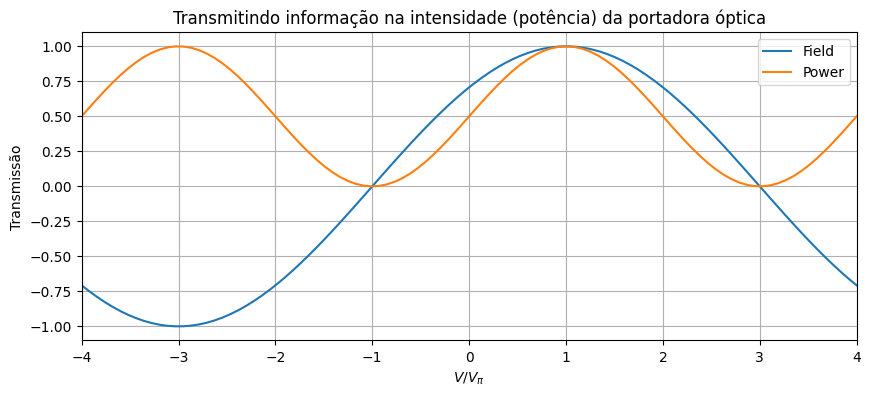

In [77]:
# Configuração push-pull
fig0 = plt.figure(num=None, figsize=(10, 4))
plt.plot(V, MZM(V, Vb[0], Vpi), label = 'Field')
plt.plot(V, np.abs(MZM(V, Vb[0], Vpi))**2, label = 'Power')
plt.title("Transmitindo informação na intensidade (potência) da portadora óptica")
plt.xlabel(r'$V/V_\pi$')
plt.ylabel('Transmissão')
plt.xlim([Vmin, Vmax])
plt.grid(True)
plt.legend();

Transmitindo informação na amplitude do campo elétrico ($V_{b}=\pm V_{\pi}.$)

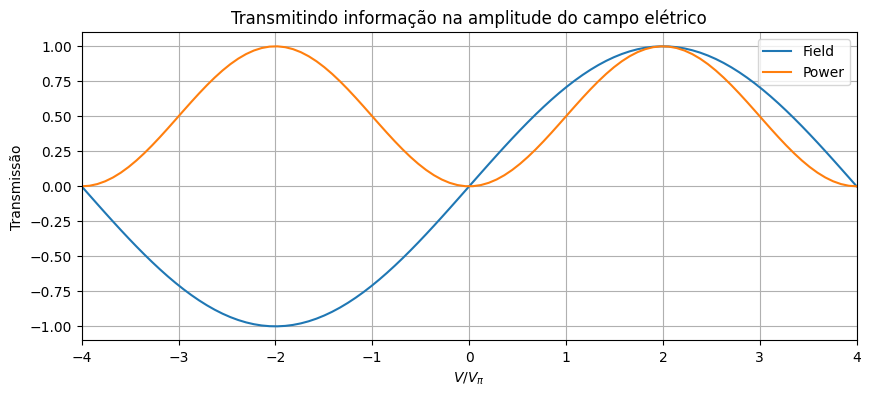

In [78]:
# Configuração push-pull
fig1 = plt.figure(num=None, figsize=(10, 4))
plt.plot(V, MZM(V, Vb[1], Vpi), label = 'Field')
plt.plot(V, np.abs(MZM(V, Vb[1], Vpi))**2, label = 'Power')
plt.title("Transmitindo informação na amplitude do campo elétrico")
plt.xlabel(r'$V/V_\pi$')
plt.ylabel('Transmissão')
plt.xlim([Vmin, Vmax])
plt.grid(True)
plt.legend();

Nesta configuração podemos transmitir informações modulando apenas a fase ou a amplitude da portadora óptica, quando temos apenas um modulador MZM. Assim admitindo esta configuração é possível gerar pulsos para transmitir esquemas de uma dimensão como no caso do OOK e PAM permitindo utilizar um MZM para modular em amplitude.

Dado que uma modulação digital é uma função $F$ que mapeia bits ou  conjuntos de bits a símbolos (fasores) no plano complexo

$$F:\{0,1\}^{k}\rightarrow\{A_{m},\theta_{m}\}_{m=1}^{M}$$

$\{0,1\}\rightarrow\{(0,0),(A,0)\}$ (Modulação OOK)

$\{(0,0),(0,1),(1,0),(1,1)\}\rightarrow\{(0,0),(A/3,0),(2A/3,0),(A,0)\}$ (Modulação 4-PAM)

Note que nestes esquemas **não** temos variações de fase. Em casos de querermos transmitir modulações como por exemplo 64-QAM podemos simplesmente realizar a combinação de dois sinais 8-PAM em quadratura.

### Simulação de modulação de pulsos elétricos a partir de um modelo MZM

Nesta simulação admitimos que a modulação óptica será feita a partir de um MZM utilizando esquemas de uma dimensão para modular em amplitude.

<br>
<center>
    <img src="https://i.postimg.cc/pLGPS6qJ/Screenshot-from-2024-02-24-22-19-52.png height="562" width="819">
</center>
<br>

#### Parâmetros do transmissor

In [79]:
# Parâmetros da simulação.
M = 4                   # Ordem da modulação
constType = 'pam'       # Esquema de modulação
pulseType = 'nrz'       # Pulso a ser utilizado
Rs = 100e6              # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 1024           # Número de coeficientes do filtro RC
alpha = 0.05            # Rolloff

#### Fonte de informação binária

Gera um bit-stream de maneira pseudo-aleatória a partir de uma distribuição uniforme discreta.

In [80]:
# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(25e4*np.log2(M)))

#### Mapeia a sequência de bits para símbolos em um determinado esquema de modulação

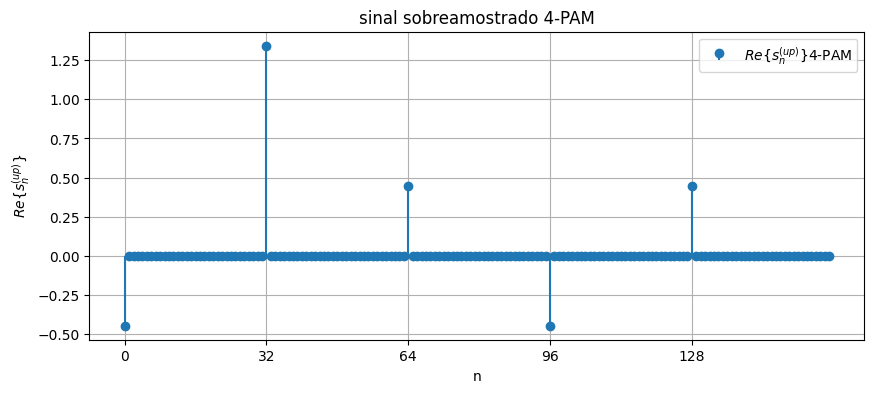

In [81]:
# Gera o mapeamento dos bits para símbolos M-PAM
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

symbolsUp = upsample(symbTx, SpS)

plt.figure(1, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].real, basefmt=" ", label ='$Re\{s_n^{(up)}\}$'+str(M)+'-'+str(constType.upper()))
plt.xlabel('n')
plt.ylabel('$Re\{s_n^{(up)}\}$')
plt.grid()
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-'+str(constType).upper());

Partindo de uma sequência de símbolos gerados a partir de um esquema de modulação digital podemos construir um sinal em banda base na forma de um trem de pulsos. Seja $s(t)$ o sinal modulado em banda base representando a sequência de símbolos $s_k$ formatada com um pulso 
$p(t)$, temos que

$$s(t)=\sum_{n=-\infty}^{\infty}s_{n}p\left(t-n T s\right)$$

Nesta simulação podemos utilizar diversas formas de pulso para interpolar os simbolos do transmissor a um formato de pulso desejado. Perceba que $s(t)$ pode ser gerado a partir de uma convolução entre um trem de impulsos e o pulso $p(t)$

$$\begin{array}{c}{{s(t)=\left[\sum_{n=-\infty}^{\infty}s_{n}\delta\left(t-n T s\right)\right]*p(t)}}\\ \\ {{=\sum_{n=-\infty}^{\infty}s_{n}p\left(t-n T s\right)}}\end{array}$$

O sinal $s_k$, por sua vez, poderá ser transmitido diretamente na banda base ou utilizado na modulação de uma onda portadora.

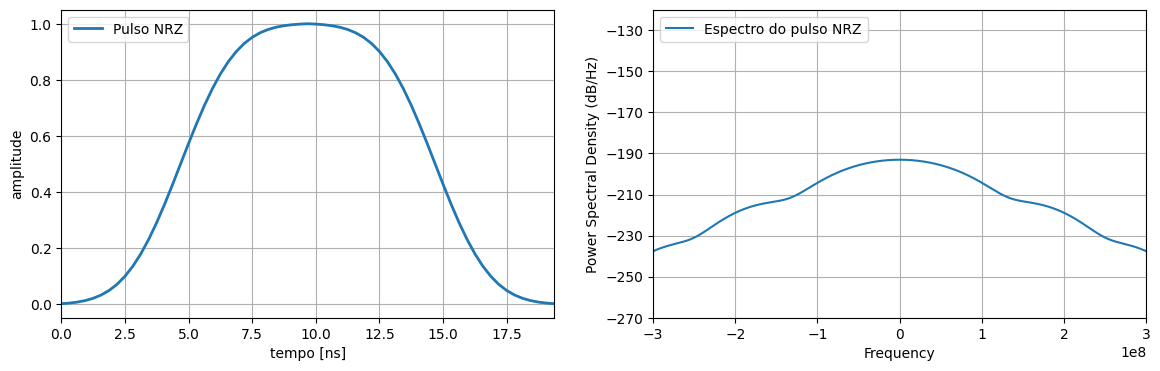

In [82]:
# seleciona o pulso desejado.
if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rc":
    pulse = pulseShape(pulseType, SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(abs(pulse))

t = np.arange(pulse.size)*(Ta/1e-9) # tempo em nano segundos amostrados em Ta

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(t, pulse, '-', linewidth=2, label = 'Pulso '+str(pulseType.upper()))
axs[0].set_xlabel('tempo [ns]')
axs[0].set_ylabel('amplitude')
axs[0].set_xlim(min(t), max(t))
axs[0].legend(loc='upper left');
axs[0].grid(True)

# plot psd
axs[1].set_xlim(-3*Rs, 3*Rs)
axs[1].set_ylim(-270, -120)
axs[1].psd(np.abs(pulse)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do pulso '+str(pulseType.upper()))
axs[1].legend(loc='upper left');

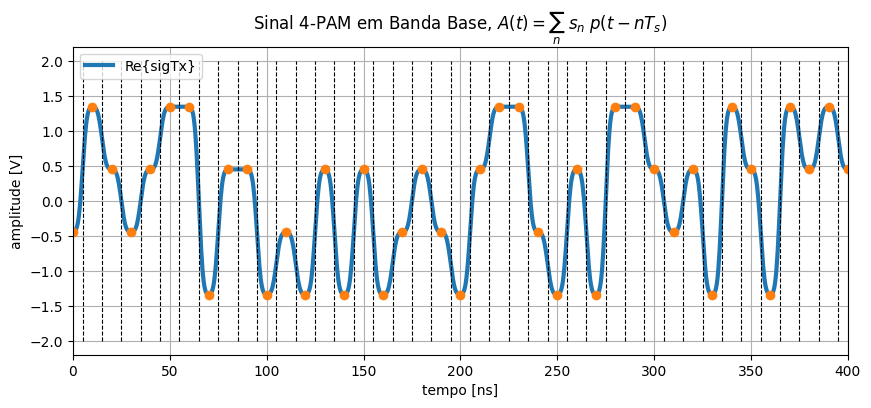

In [83]:
# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
t = np.arange(0, sigTx.size)*(Ta)/1e-9

# instantes centrais de sinalização.
symbolsUp[symbolsUp==0] = np.nan

plt.figure(1, figsize=(10, 4))
plt.plot(t, sigTx.real, '-', linewidth=3, label='Re{sigTx}')
#plt.plot(t, sigTx.imag, '-', linewidth=3, label='Im{sigTx}')
plt.plot(t, symbolsUp.real, 'o') 
plt.title('Sinal ' + str(M) + '-' + str(constType.upper()) + ' em Banda Base, $A(t)=\sum_{n}\;s_{n}\;p(t-n T_s)$')
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True)

t = (0.5 + np.arange(bits.size))*(Ts/1e-9)
plt.vlines(t, -2, 2, linestyles='dashed', linewidth=0.8, color = 'k');

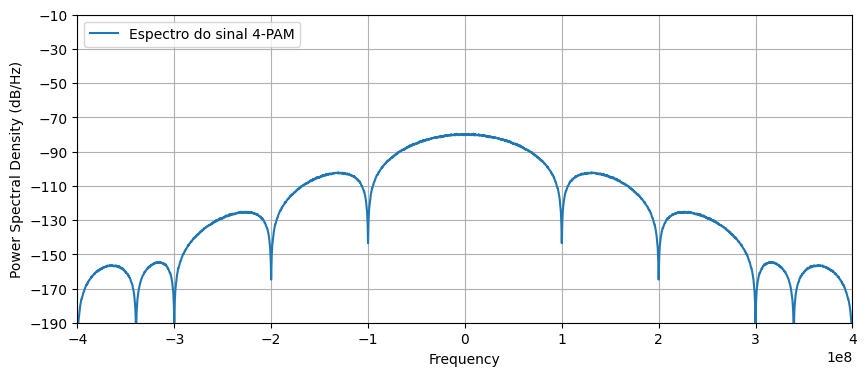

In [84]:
# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-4*Rs, 4*Rs)
plt.ylim(-190, -10)
plt.psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal '+ str(M) +'-'+str(constType.upper()))
plt.legend(loc='upper left');

### Modulando a partir de um MZM

In [85]:
# Laser power
Pi_dBm = -16        # potência óptica do laser na entrada do MZM em dBm
Pi = dBm2W(Pi_dBm)  # converter de dBm para W

# parâmetros do MZM
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx.real, paramMZM)

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

Potência média do sinal óptico modulado [mW]: 0.013 mW
Potência média do sinal óptico modulado [dBm]: -19.010 dBm


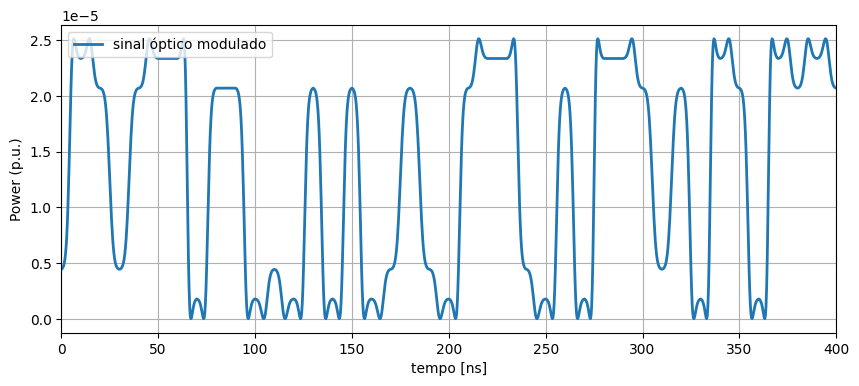

In [86]:
t = np.arange(0, sigTxo.size)*(Ta/1e-9)
plt.figure(figsize=(10, 4))
plt.plot(t, np.abs(sigTxo)**2, linewidth=2, label = 'sinal óptico modulado')
plt.xlabel('tempo [ns]')
plt.ylabel('Power (p.u.)')
plt.xlim(min(t), 400)
plt.legend(loc='upper left')
plt.grid(True);

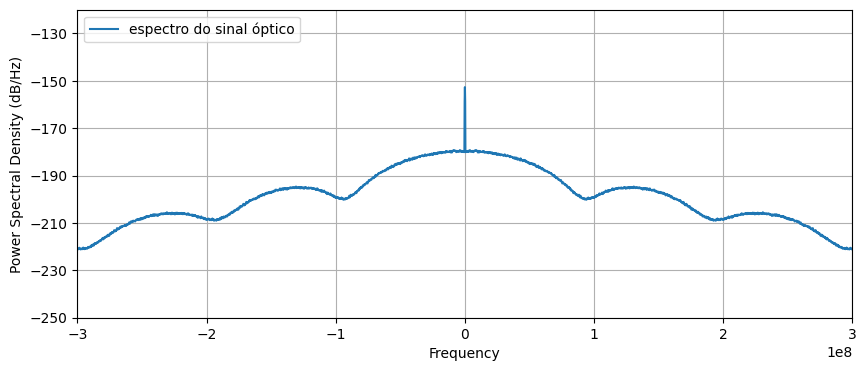

In [87]:
# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-3*Rs, 3*Rs)
plt.ylim(-250, -120)
plt.psd(np.abs(sigTxo)**2, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'espectro do sinal óptico')
plt.legend(loc='upper left');

### Diagramas de olho
O diagrama de olho é uma representação gráfica que nos permite aferir a qualidade de um sinal e sua integridade num sistema de comunicação digital, permitindo a avaliação de métricas de qualidade do sinal e a identificação de possíveis problemas, como interferências ou distorções. 

O [diagrama de olho](https://i.postimg.cc/ydmV3fBq/eyeDisp.gif) é composto por um conjunto de curvas que representam a variação do sinal ao longo do tempo. Cada curva é gerada pela sobreposição de várias amostras do sinal, permitindo que sejam identificadas as variações que ocorrem durante a transmissão.

Abaixo podemos observar o diagrama de olho para o sinal elétrico modulado em banda base, desprezando o ruído. Como estamos utilizando um esquema de modulação apenas em uma dimensão como no caso do PAM então veremos apenas o diagrama de olho para a parte real do sinal elétrico.

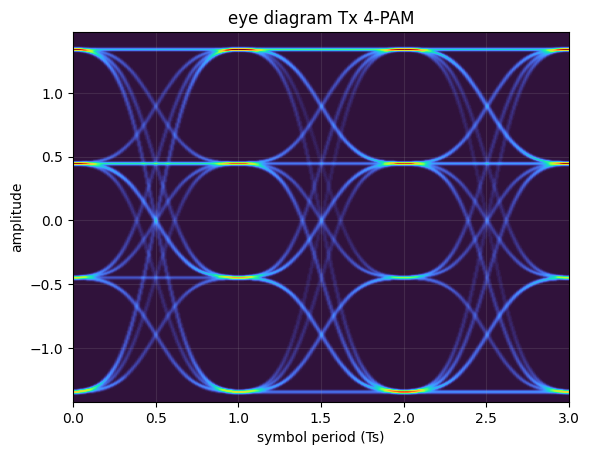

In [88]:
# diagrama de olho para o sinal em banda base.
NsamplesTx = sigTx.size
figureTx = eyediagram(sigTx, NsamplesTx, SpS, plotlabel = 'Tx '+str(M)+'-'+str(constType).upper(), ptype='fancy')

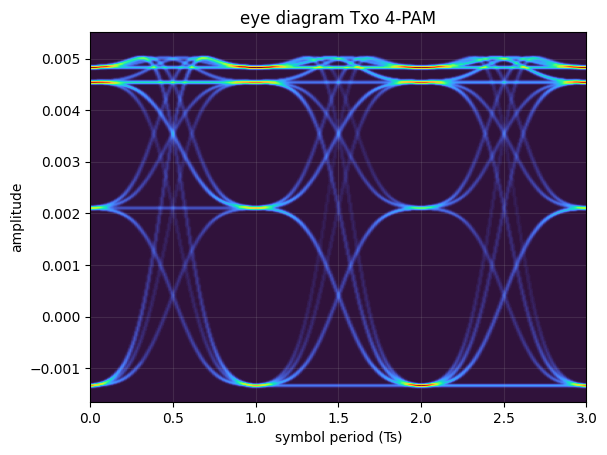

In [89]:
# diagrama de olho para o sinal óptico
NsamplesTxo = sigTxo.size
figureTx = eyediagram(sigTxo, NsamplesTxo, SpS, plotlabel = 'Txo '+str(M)+'-'+str(constType).upper(), ptype='fancy')

Em caso de introduzirmos ruído gaussiano a uma determinada sequência de pulsos modulados poderemos aferir a partir do diagrama de olho o nível de ruído presente, tornando a "abertura do olho" mais fechada, dificultando ainda mais a recuperação dos bits transmitidos pelo transmissor, consequentemente diminuindo a SNR (Relação Sinal-Ruído)

A partir de um ruído gaussiano teremos:

$$y_{k}^{I}=x_{k}^{I}+\eta_{k}^{I}$$
$$y_{k}^{Q}=x_{k}^{Q}+\eta_{k}^{Q}$$

Onde $\eta_{k}^{I}$ e $\eta_{k}^{Q}$ são processos de ruído gaussiano branco com média zero e variância $N_0/2$ nas componentes em fase e quadratura. A SNR é calculada como a razão entre a potência do sinal e do ruído considerando tanto a componente de fase quanto a componente de quadratura, podendo ser expressa como:

$$SNR = \frac{E_s}{N_0} = \frac{P_s}{P_n}$$
$$P_{s}=E\left[|s(t)|^{2}\right]$$
$$P_{n}=E\left[|n(t)|^{2}\right]$$

A SNR é um indicador da presença de ruído no sistema, ou seja, a presença de distorções aleatórias e indesejáveis que afetam os sinais que carregam informação, dificultando ou impossibilitando o processo de comunicação.


### Gerando um ruído gaussiano

A densidade de probabilidade para a distribuição gaussiana é

$$p(x)={\frac{1}{{\sqrt{2\pi\sigma^{2}}}}}e^{-{\frac{(x-\mu)^{2}}{2\sigma^{2}}}}$$

onde $\mu$ é a média e $\sigma$ o desvio padrão, o quadrado do desvio padrão $\sigma²$, é chamada de variância.

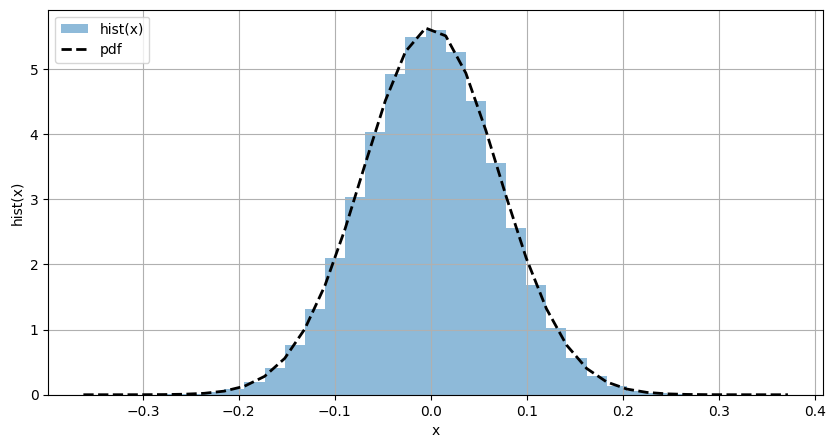

In [90]:
samples = sigTx.size    # amostras
σ2 = 0.0050             # variância
μ  = 0                  # média
σ  = np.sqrt(σ2)        # devio padrão

# Gerando ruído branco
noise = np.random.normal(μ, σ, samples)

# histograma das amostras, juntamente com a função de densidade de probabilidade                               
plt.figure(None, figsize=(10, 5))
count, bins, ignored = plt.hist(noise, 35, density=True, label='hist(x)', alpha=0.5)
plt.plot(bins, 1/(σ * np.sqrt(2*np.pi)) * np.exp(-(bins - μ)**2 / (2 * σ**2)), '--', linewidth=2, label='pdf', color='black')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('hist(x)')
plt.grid(True);

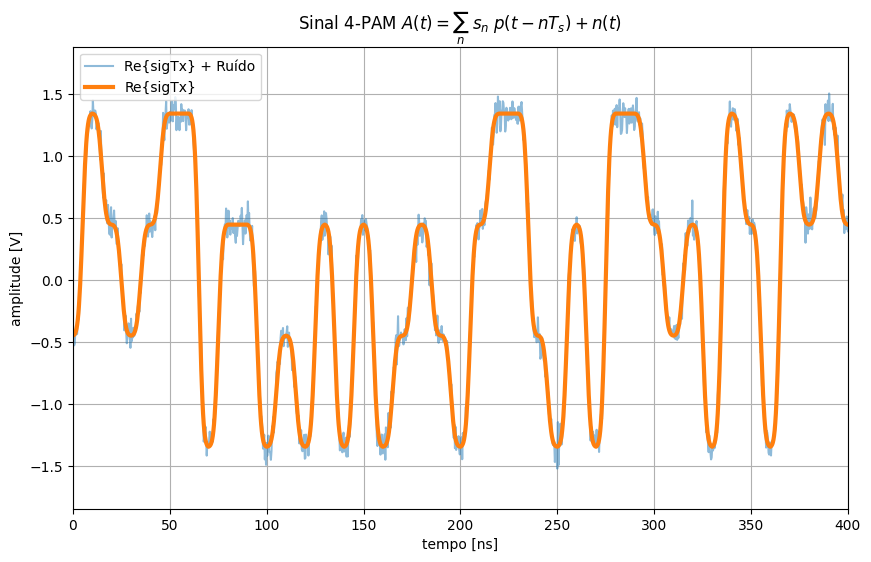

In [91]:
t = np.arange(0, sigTx.size)*(Ta)/1e-9

plt.figure(1, figsize=(10, 6))
plt.plot(t, sigTx.real + noise, '-', linewidth=1.5, alpha=0.5, label='Re{sigTx} + Ruído')
plt.plot(t, sigTx.real, '-', linewidth=3, label='Re{sigTx}')
plt.title('Sinal ' + str(M) + '-' + str(constType.upper()) + ' $A(t)=\sum_{n}\;s_{n}\;p(t-n T_s) + n(t)$')
plt.xlim(min(t), 400)
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude [V]')
plt.legend(loc='upper left')
plt.grid(True)

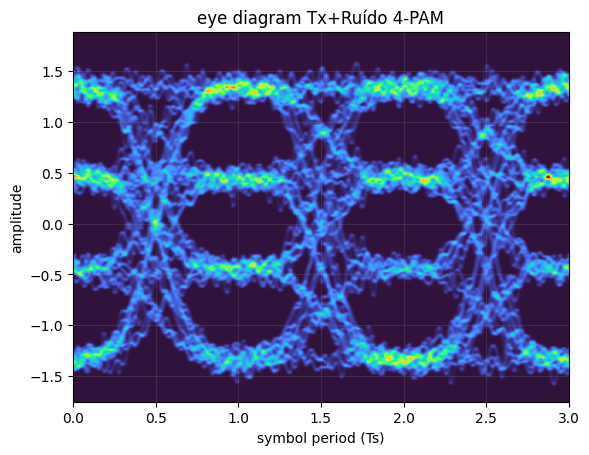

In [92]:
# diagrama de olho para o sinal em banda base com ruído gaussiano associado.
NsamplesTx = sigTx.size
figureTx = eyediagram(sigTx + noise, NsamplesTx, SpS, plotlabel = 'Tx+Ruído '+str(M)+'-'+str(constType).upper(), ptype='fancy')

### Cálculo da SNR

E possível calcular a SNR em dB da seguinte maneira:

$$\mathrm{SNR}_{dB}=10\log_{10}P_{s}-10\log_{10}P_{n}$$

Onde $P_{s}$ é a potência do sinal e $P_{n}$ é a potência do ruído

In [93]:
SNR = 10*np.log10(signal_power(sigTx)/signal_power(noise))
print(f'SNR = {round(SNR, 2)} dB')

SNR = 22.1 dB


### 2.3.3 In-Phase and Quadrature Modulator

# Referências 

[1] Digital Coherent Optical Systems, Architecture and Algorithms